In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit.Chem import Draw
from sklearn import manifold
from rdkit import DataStructs
import matplotlib.pyplot as plt
from scipy.spatial import distance
from rdkit.Chem import Descriptors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.preprocessing import StandardScaler
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# VEGF and picking

In [2]:
df = pd.read_csv('VEGF2.csv')
df = df.drop(['tid', 'standard_type', 'confidence_score', 'cmpd_pref_name', 'activity_comment'], axis=1)
df['mol'] = [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]
df.head()

,cmpd_chembl_id,canonical_smiles,value,mol
0,CHEMBL356626,CCCOCc1ccc2c(c1)c3c4CNC(=O)c4c5c(Cc6ccccc56)c3...,7.890,<rdkit.Chem.rdchem.Mol object at 0x000001BDF45...
1,CHEMBL171558,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN5CCOCC5,6.600,<rdkit.Chem.rdchem.Mol object at 0x000001BDF45...
2,CHEMBL221053,CCc1cccc(NC(=O)Nc2ccc(cc2)c3cccc4[nH]nc(N)c34)c1,8.220,<rdkit.Chem.rdchem.Mol object at 0x000001BDF45...
3,CHEMBL3754450,COc1cccc(c1)C(=O)CN2CCN(CC2)c3nnc(c4ccccc4)c5c...,5.470,<rdkit.Chem.rdchem.Mol object at 0x000001BDF45...
4,CHEMBL383255,Cn1cnc(NCc2ccncc2)c1c3oc(Nc4ccc(OC(F)(F)F)cc4)nn3,7.105,<rdkit.Chem.rdchem.Mol object at 0x000001BDF45...


In [3]:
drug = Chem.SDMolSupplier('drugbank.sdf')

In [6]:
finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in df.mol] #do vzdálenosti 2
df['finger'] = finger

In [7]:
ids=[]
for i in range(len(drug)):
    if drug[i] is not None:
        ids.append(drug[i].GetProp('DATABASE_ID')) 

In [8]:
inchi=[]
for i in range(len(drug)):
    if drug[i] is not None:
        inchi.append(drug[i].GetProp('INCHI_IDENTIFIER')) 

In [9]:
data = {'id': ids,
        'inchi': inchi}
drug_df = pd.DataFrame(data, columns = ['id', 'inchi'])

In [10]:
drug_df['mol'] = [Chem.inchi.MolFromInchi(i) for i in drug_df['inchi']]
drug_df = drug_df.dropna()

In [11]:
drug_finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in drug_df.mol]
drug_df['finger'] = drug_finger

### MQNs

In [33]:
MQNs = np.array([rdMolDescriptors.MQNs_(i) for i in df.mol] + [rdMolDescriptors.MQNs_(i) for i in drug_df.mol])
df_MQNs = pd.DataFrame(MQNs)
df_MQNs['source'] = d.source

### PCA

shape:  (13827, 19)


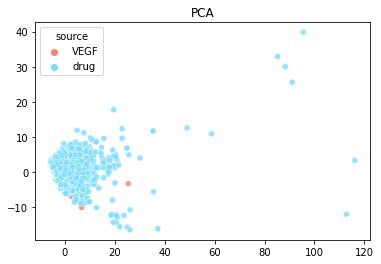

In [39]:
pca = PCA(0.9)
MQNs_2 = StandardScaler().fit_transform(MQNs)
PCA_com = pca.fit_transform(MQNs_2)
colors =['salmon','#7BDDFF'] # #FF7BD7
plot = sns.scatterplot(x=PCA_com[:,0], y=PCA_com[:,1], hue=df_MQNs['source'], alpha=0.8, palette=colors).set_title('PCA')
print('shape: ', PCA_com.shape)

### MDS

shape:  (13827, 2)


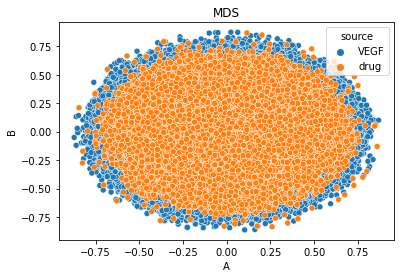

In [61]:
fps_mds = pd.read_csv('MDS.txt', sep=' ')
plot = sns.scatterplot(x=fps_mds["0"], y=fps_mds["1"], hue=d['source']).set_title('MDS')
print('shape: ', fps_mds.shape)

### t-SNE

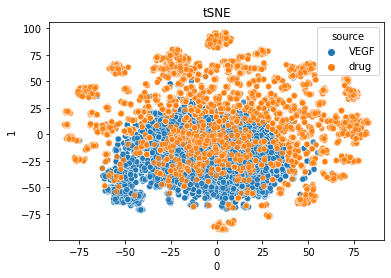

In [126]:
fps_tsne = pd.read_csv('tSNE.txt', sep=' ')
plot = sns.scatterplot(x=fps_tsne["0"], y=fps_tsne["1"], hue=d['source'], alpha=0.8).set_title('tSNE')

# Diversity picking
### Vyber reprezentativni podmonoziny

In [73]:
def distance_function(i1, i2, *args, fingerprints=finger, metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[i1], fingerprints[i2], metric=metric)

In [74]:
distance_function(0,1)

0.8454545454545455

In [79]:
# Now create a picker and grab a set of 45 diverse molecules and return indexs of structures
picker = MaxMinPicker()
picks = list(picker.LazyPick(distance_function, len(df.mol), 100))
picks[:10]

[706, 401, 5340, 3813, 3621, 2232, 5107, 5194, 2512, 2571]

In [109]:
res = []
for i in range(len(finger)):
    if i in picks:
        res.append("1")
    else:
        res.append("0")

In [127]:
df["pick"] = res

In [ ]:
pca = PCA(0.9)
finger_2 = StandardScaler().fit_transform(finger)
PCA_com = pca.fit_transform(finger_2)

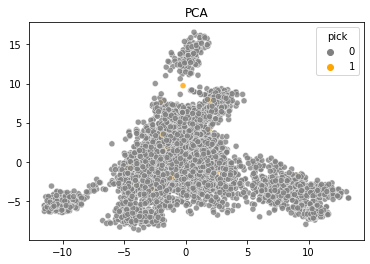

In [119]:
colors = ['grey','orange'] 
plot = sns.scatterplot(x=PCA_com[:,0],y=PCA_com[:,1], hue=df['pick'], alpha=0.8, palette=colors).set_title('PCA') 

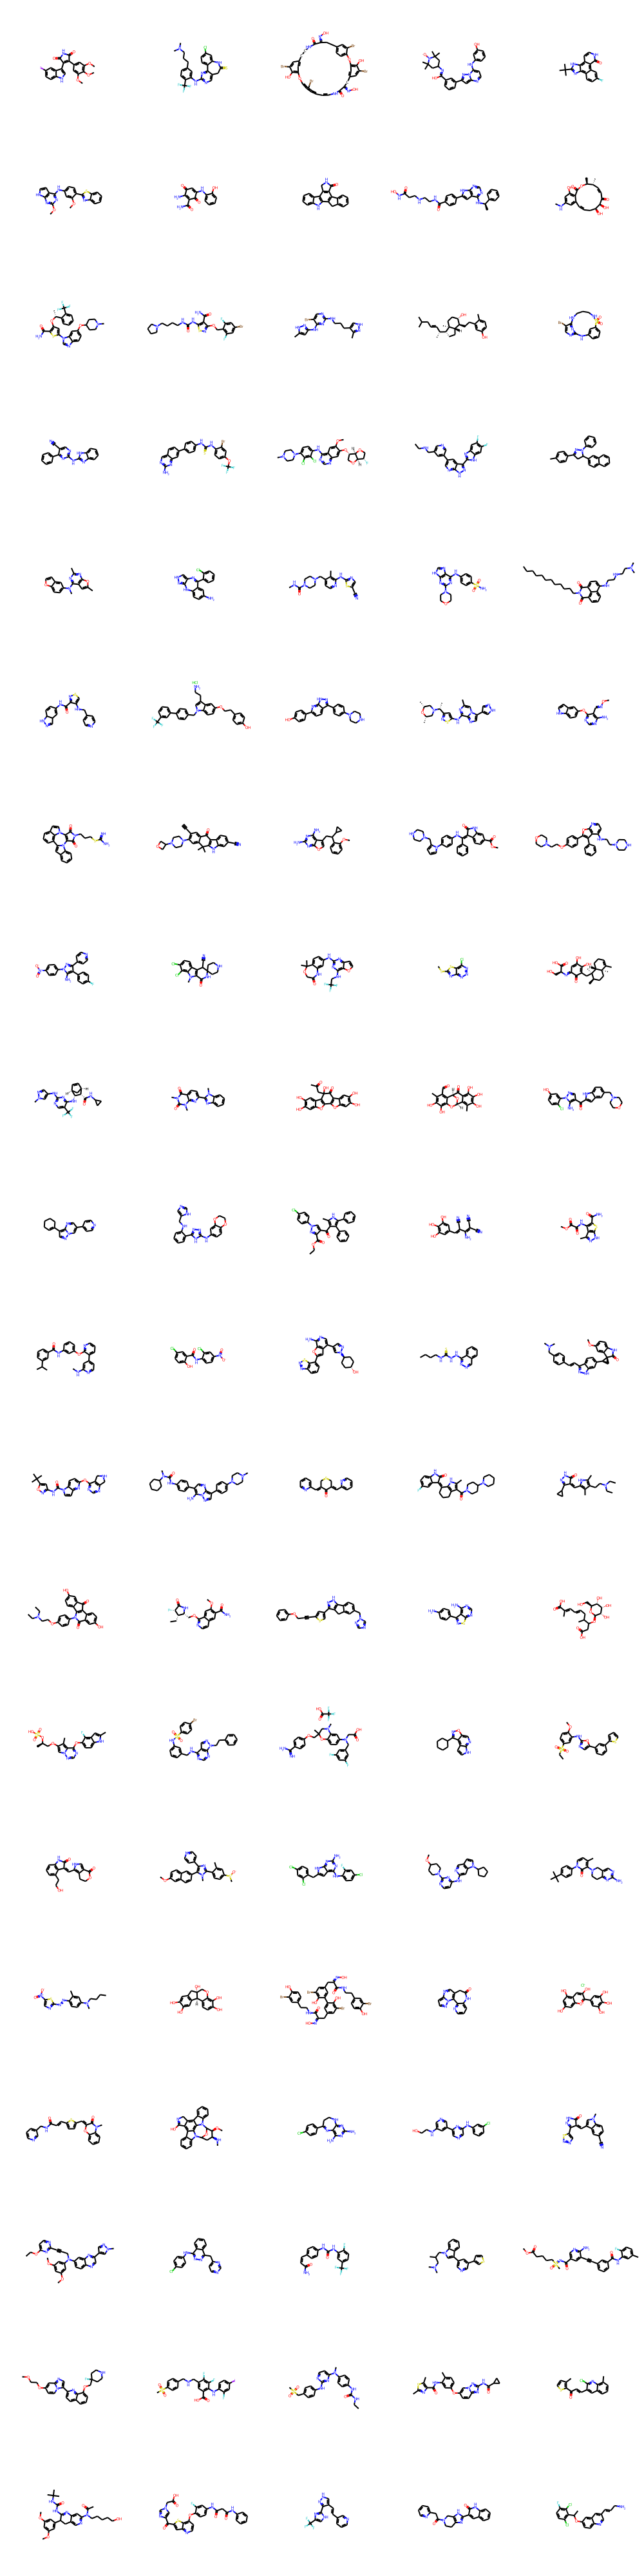

In [205]:
# Vybrane struktury
Draw.MolsToGridImage(df[df["pick"]=="1"]['mol'], molsPerRow=5, maxMols=100)

In [159]:
def similarity(dataset = finger):
    sim = []
    for k in range(len(dataset)):
        for i in range(len(dataset)):
            sim.append(distance_function(k, i, fingerprints=dataset))
    return sim

In [160]:
# prumerna vzdalenost mezi vybranymi
sim = similarity(list(df[df['pick']=="1"].finger))
sum(sim)/len(sim)

0.8873164986948198

In [162]:
# prumerna vzdalenost mezi vsemi
sim_all = similarity(finger)
sum(sim_all)/len(sim_all)

0.8412375874825396

# Scaffolds

In [181]:
sc1 = [MurckoScaffold.GetScaffoldForMol(x) for x in df.mol]
sc2 = [MurckoScaffold.MakeScaffoldGeneric(x) for x in sc1]
sc3 = [MurckoScaffold.GetScaffoldForMol(x) for x in sc2]

In [ ]:
df["scaffold1"] = sc1
df["scaffold2"] = sc2
df["scaffold3"] = sc3

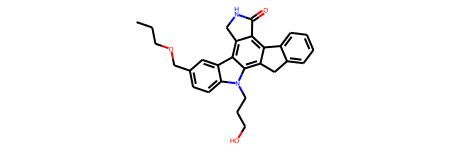

In [193]:
df.mol[0]

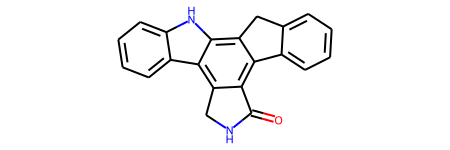

In [190]:
sc1[0]

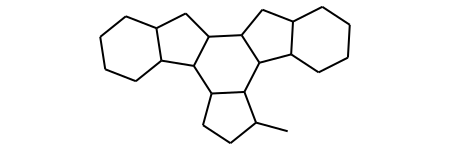

In [191]:
sc2[0]

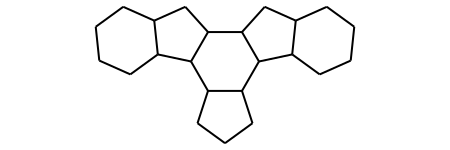

In [192]:
sc3[0]

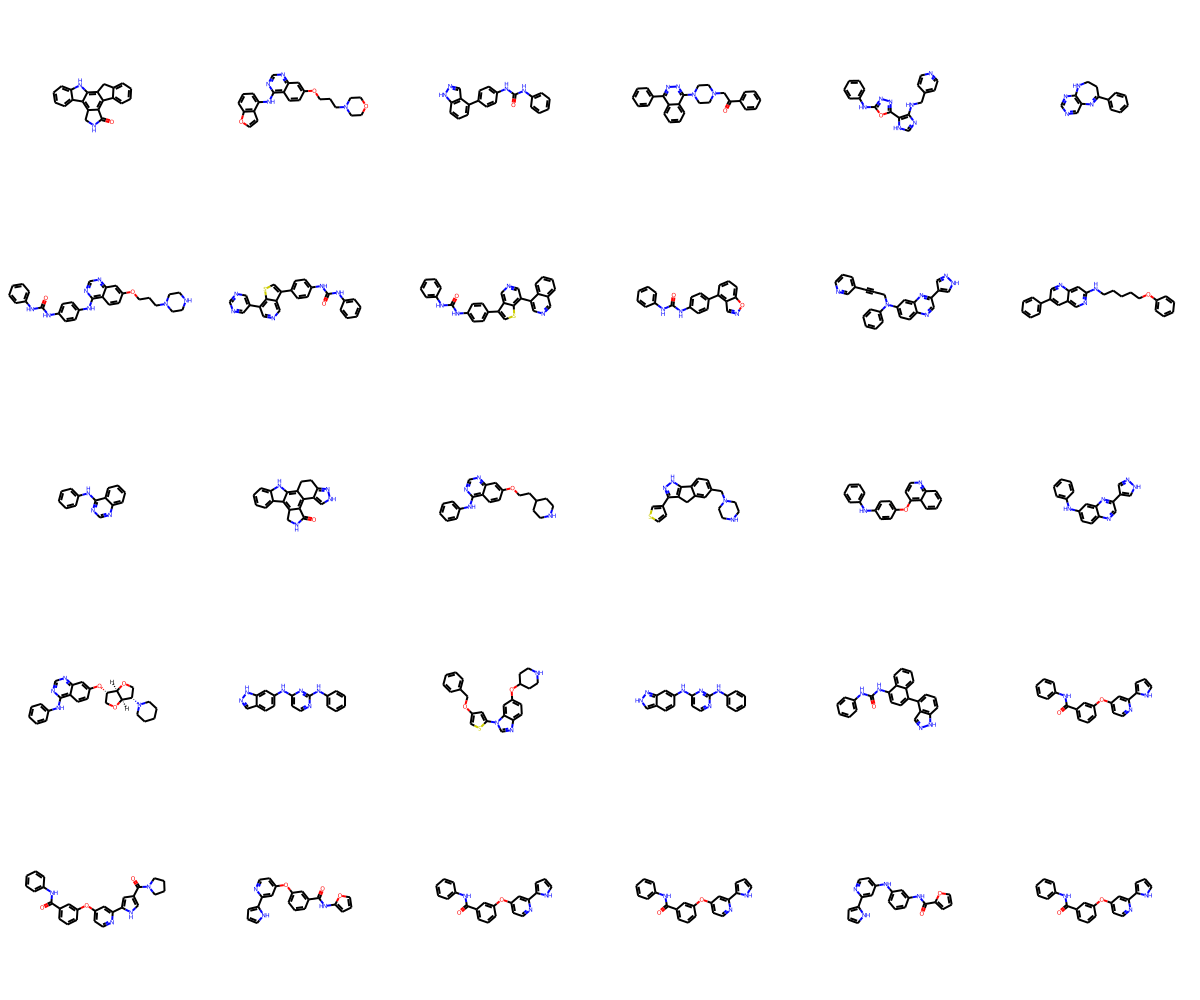

In [204]:
Draw.MolsToGridImage(df['scaffold1'], molsPerRow=6, maxMols=30)

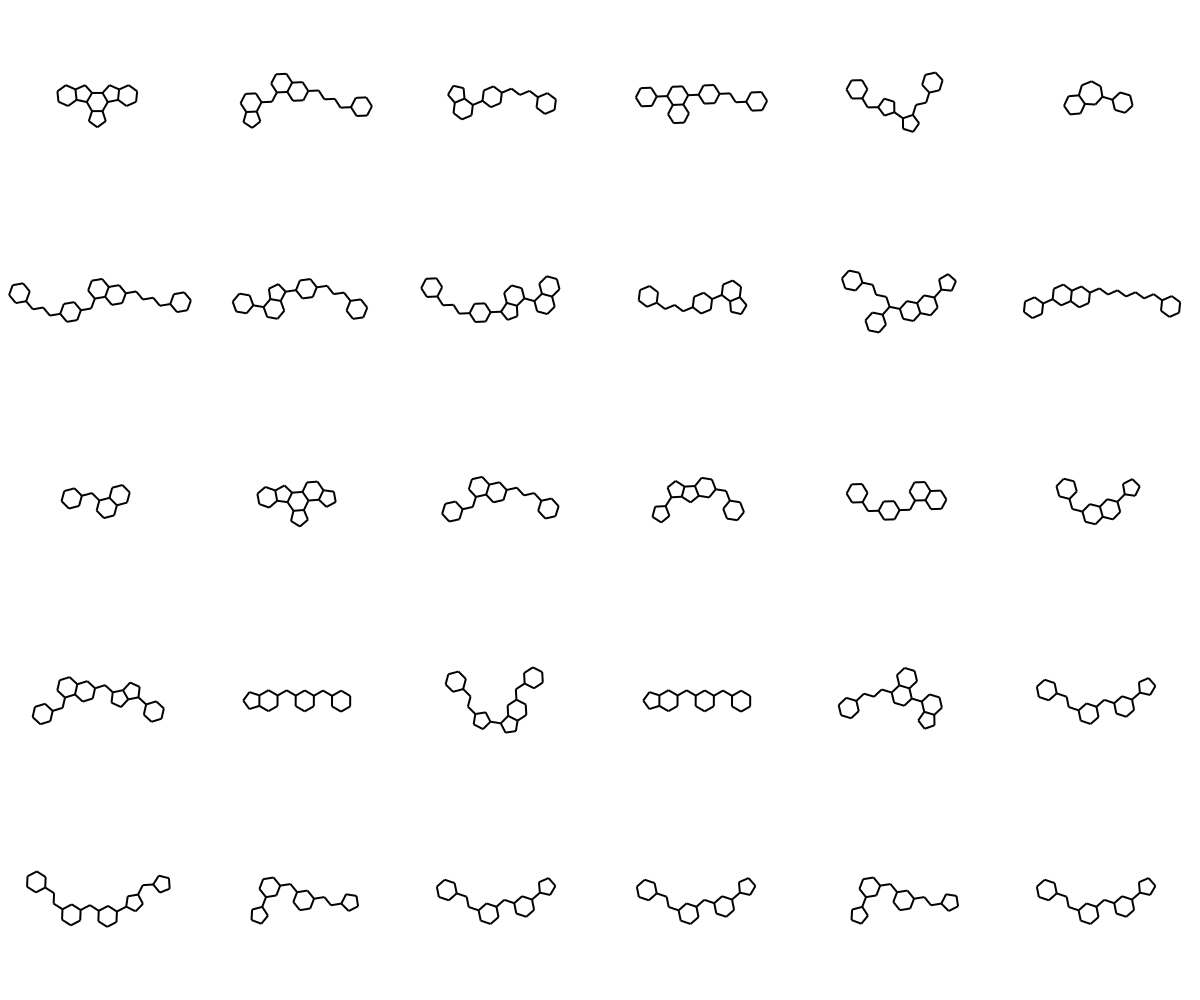

In [200]:
Draw.MolsToGridImage(df['scaffold3'], molsPerRow=6, maxMols=30)